<a href="https://colab.research.google.com/github/zhuchangyan/Multimode-fiber-Image-reconstruction/blob/master/Debug_is_xuanxue.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

这里是CVAE用来还原multimode fiber图像的代码。

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
cd /content/drive/My Drive/Colab Notebooks/MMF data/

/content/drive/My Drive/Colab Notebooks/MMF data


In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

import os
import time
import numpy as np
import glob
import matplotlib.pyplot as plt
import PIL
import imageio

from IPython import display
import pickle

TensorFlow 2.x selected.


In [0]:
class CVAE(tf.keras.Model):
  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.inference_net = tf.keras.Sequential(
      [
          tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
          tf.keras.layers.Conv2D(
              filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
          tf.keras.layers.Conv2D(
              filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
          tf.keras.layers.Flatten(),
          # No activation
          tf.keras.layers.Dense(latent_dim + latent_dim),
      ]
    )

    self.generative_net = tf.keras.Sequential(
        [
          tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
          tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
          tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
          tf.keras.layers.Conv2DTranspose(
              filters=64,
              kernel_size=3,
              strides=(2, 2),
              padding="SAME",
              activation='relu'),
          tf.keras.layers.Conv2DTranspose(
              filters=32,
              kernel_size=3,
              strides=(2, 2),
              padding="SAME",
              activation='relu'),
          # No activation
          tf.keras.layers.Conv2DTranspose(
              filters=1, kernel_size=3, strides=(1, 1), padding="SAME"),
        ]
    )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.inference_net(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def reconstruct(self, x):
    mean, logvar = self.encode(x)
    z = self.reparameterize(mean, logvar)
    x_logit = self.decode(z)
    return x_logit

  def decode(self, z, apply_sigmoid=False):
    logits = self.generative_net(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs

    return logits

In [0]:
optimizer = tf.keras.optimizers.Adam(1e-4)

def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)

@tf.function
def compute_loss(model, x , x_prime ):
  mean, logvar = model.encode(x_prime)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)

  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)

@tf.function
def compute_apply_gradients(model, x, x_prime, optimizer):
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x, x_prime)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

Load the data

In [0]:
with open('resize_cut_10000.dat','rb') as f:
  imgs = pickle.load(f)

with open('resize_10000_SLM.dat','rb') as f:
  origins = pickle.load(f)

imgs = np.array(imgs)
origins = np.array(origins)

N_input = 10000
N_train = 8000
N_test = 2000

train_imgs = imgs[0:8000].reshape(-1,28,28,1).astype('float32')
train_origins = origins[0:8000].reshape(-1,28,28,1).astype('float32')
test_imgs = imgs[8000:10000].reshape(-1,28,28,1).astype('float32')
test_origins = origins[8000:10000].reshape(-1,28,28,1).astype('float32')


for i in range(8000):
  train_imgs[i] = train_imgs[i]/255.0
  train_origins[i] = train_origins[i]/255.0

for i in range(2000):
  test_imgs[i] = test_imgs[i]/255.0
  test_origins[i] = test_origins[i]/255.0


In [0]:
def next_batch(batch_size, data_input, data_output):
    '''
    Return a total of `batch_size` random samples 
    '''
    idx = np.arange(0 , len(data_input))
    np.random.shuffle(idx)
    idx = idx[:batch_size]
    data_shuffle_input = [data_input[i] for i in idx]
    data_shuffle_output = [data_output[i] for i in idx]
    return np.asarray(data_shuffle_input) , np.asarray(data_shuffle_output)

In [0]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model.reconstruct(test_input)
  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0], cmap='gray')
      plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [0]:
epochs = 30
latent_dim = 50
num_examples_to_generate = 16
batch_size = 10

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
input , output = next_batch (16,test_imgs,test_origins)
test_input = tf.multiply(input,1.0)
model = CVAE(latent_dim)

In [0]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_imgs,train_origins)).shuffle(N_train).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((test_imgs,test_origins)).shuffle(N_test).batch(batch_size)

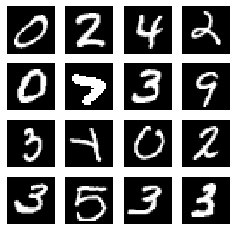

In [12]:
fig = plt.figure(figsize=(4,4))

for i in range(output.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow(output[i, :, :, 0], cmap='gray')
    plt.axis('off')

# tight_layout minimizes the overlap between 2 sub-plots
plt.show()

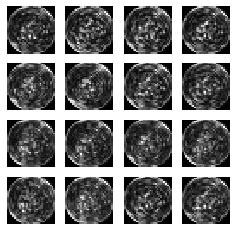

In [13]:
fig = plt.figure(figsize=(4,4))

for i in range(input.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow(input[i, :, :, 0], cmap='gray')
    plt.axis('off')

# tight_layout minimizes the overlap between 2 sub-plots
plt.show()

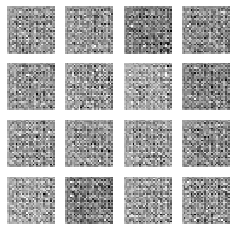

In [14]:
generate_and_save_images(model, 0, test_input)

Epoch: 30, Test set ELBO: -168.6709747314453, time elapse for current epoch 2.4822988510131836


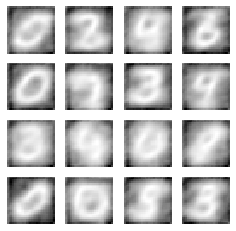

In [15]:
for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train in train_dataset:
    compute_apply_gradients(model, train[1], train[0], optimizer)
  end_time = time.time()

  if epoch % 1 == 0:
    loss = tf.keras.metrics.Mean()
    for test in test_dataset:
      loss(compute_loss(model, test[1], test[0]))
    elbo = -loss.result()
    display.clear_output(wait=False)
    print('Epoch: {}, Test set ELBO: {}, '
          'time elapse for current epoch {}'.format(epoch, elbo,end_time - start_time))
    generate_and_save_images(model, epoch, test_input)

Display an image using the epoch number

(-0.5, 287.5, 287.5, -0.5)

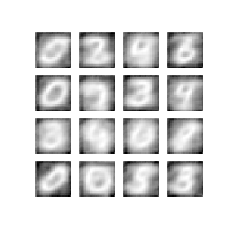

In [16]:
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

plt.imshow(display_image(epochs))
plt.axis('off')# Display images

GIF

In [0]:
anim_file = 'cvae.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info >= (6,2,0,''):
  display.Image(filename=anim_file)

In [18]:
'''
try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(anim_file)

'''

'\ntry:\n  from google.colab import files\nexcept ImportError:\n   pass\nelse:\n  files.download(anim_file)\n\n'